# Spatial equilibrium

In [1]:
using LinearAlgebra, Statistics, FFTW, Plots, FastMarching, LightGraphs, SimpleWeightedGraphs, GraphRecipes

In [2]:
# Geography
N = 8
NN = N^2

# Spatial TFPs
function spatial_tfps(N,bett=-2.5)
    # Random phase shift
    phi = rand(N,N,3)
    
    # Quadrant frequencies
    u = [(0:floor(N/2))' -(ceil(N/2)-1:-1:1)']'/N
    
    # Reproduce these frequencies
    u = repeat(u, 1, N)
    
    # v is the set of frequencies along the second dimension
    v = u'
    
    # Generate prower spectrum
    Sf = (u.^2 + v.^2).^(bett/2.0)
    
    # Set infinities to 0 (remember to use broadcasting)
    Sf[Sf .== Inf] .= 0
        
    # Inverse Fourier transform
    Aa = ifft(sqrt.(Sf) .* (cos.(2 .*π.*phi[:,:,1]) .+ im.*sin.(2 .*π.*phi[:,:,1])))
    Am = ifft(sqrt.(Sf) .* (cos.(2 .*π.*phi[:,:,2]) .+ im.*sin.(2 .*π.*phi[:,:,2])))
    As = ifft(sqrt.(Sf) .* (cos.(2 .*π.*phi[:,:,3]) .+ im.*sin.(2 .*π.*phi[:,:,3])))
    
    # Pick real part and exponentiate
    Aa = exp(real(Aa))
    Am = exp(real(Am))
    As = exp(real(As))
    
    return (Aa, Am, As) # return as tuple
end

Aa, Am, As = spatial_tfps(N,-2.6)

([0.6059617399296183 -0.08215296372558613 … -0.4016683513590049 -0.2896791122583112; -0.05728032925841676 1.2893043564189341 … -0.4889770313495436 -0.05645165296517221; … ; -0.2325829299244193 0.058653389187842915 … 0.876625177994071 -0.5106905313965213; -0.37944333048779566 -0.03475898348810078 … -0.02565086410196761 0.6410113782260176], [0.8644436013081203 -0.49304996631195763 … -0.0027931914011669 0.06339510036394085; -0.4093601785550653 0.7171610665517322 … 0.20934577170638555 -0.6209823544772852; … ; -0.1575976886369723 0.08286077886054778 … 0.828882706362665 -0.30487212781459; -0.13016685541139578 -0.2884065953754183 … 0.13570029761255184 1.4200276559760565], [0.9633741115474738 0.15960220824394497 … -0.28064526117939115 -0.11148456525879816; -0.6867154007814389 0.3248625846041667 … 0.07573440733944288 -0.5483025831673168; … ; -0.7078231407814588 -0.16538736145598276 … -0.09129164053444869 -0.7630814349485769; 0.76048225664513 -0.5135726301641155 … 0.09631166231429969 2.160166603

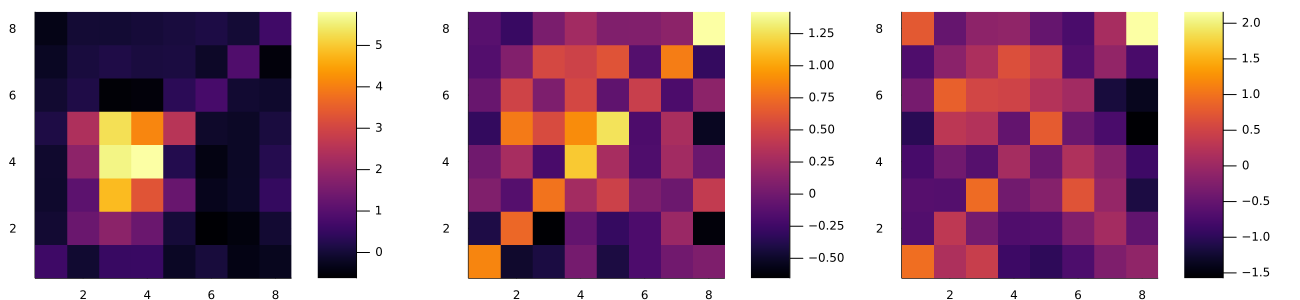

In [3]:
pa = heatmap(Aa)
pm = heatmap(Am)
ps = heatmap(As)

plot(pa,pm,ps,layout =(1, 3), size = (1300, 300))

In [4]:
# Fundamental parameters
# Elasticities of substitution
rho = 1         # Across sectors
sigm = 5        # Across varieties
bbi  = -0.3     # Amenities parameter
nu   = 0.97     # 1 - nu = exp in electricity

# Utility weights
oma = 0.177
omm = 0.325
oms = 1-oma-omm

# Sector-location intensity in labor 
betas = ones(NN,3)

# From Perez-Sebastian, Steinbuks, Feres, and Trotter (2019)    Table 5
ba = 0.509
bm = 0.335
bs = 0.644

betas = [ba, bm, bs]

# Spillovers
alphT = [0.11, 0.09, 0.05]
iotT = [0.11, 0.09, 0.05]
muT = [0.01, 0.05, 0.05]

# Elasticity of transport costs to infrastructure
gamm = 0.84

# Randomness on ruggedness of terrain
rugg = exp.(randn(N,N))
rugg = N.*ones(size(rugg))./rugg
rugg = 10 ./ rugg

# Distance through terrain
delT = zeros(NN,NN)
index = CartesianIndices(ones(N,N))
rows = map(i -> i[1], index)
cols = map(i -> i[2], index)
rows = rows[:]
cols = cols[:]
for z in 1:NN
    strt = [float(rows[z]); float(cols[z])] # The starting point has to be a column vector
    temp = FastMarching.msfm(rugg, strt, true, true) # Use second derivatives and cross derivatives
    delT[z,:] = reshape(temp,1,NN) .* 10
end

delT[diagind(delT)] .= 1
delT = delT.^(1/4)

# Make sure it is symmetric
delT = (delT + delT') ./ 2.0
delT[delT .< 1] .= 1

0-element view(::Vector{Float64}, Int64[]) with eltype Float64

In [5]:
# Function to create adjacency matrix
function create_map(w,h,cross_nodes = false)
    N = w*h
    
    # Struct array of nodes
    nodes = []
    delta = zeros(N,N)
    x = zeros(N,1)
    y = zeros(N,1)
    
    for n in 1:N
        neighbors = []
        
        y[n] = Int(floor((n - 1)/w) + 1)
        x[n] = Int(n - w*(y[n] - 1)+0)
        
        if x[n]<w
            neighbors = push!(neighbors,x[n]+1+w*(y[n]-1));
            delta[Int(x[n]+w*(y[n]-1)),Int(x[n]+1+w*(y[n]-1))]=1;
        end
        if x[n]>1
            neighbors = push!(neighbors,x[n]-1+w*(y[n]-1));
            delta[Int(x[n]+w*(y[n]-1)),Int(x[n]-1+w*(y[n]-1))]=1;
        end
        if y[n]<h
            neighbors = push!(neighbors,x[n]+w*(y[n]+1-1));
            delta[Int(x[n]+w*(y[n]-1)),Int(x[n]+w*(y[n]+1-1))]=1;
        end
        if y[n]>1
            neighbors = push!(neighbors,x[n]+w*(y[n]-1-1));
            delta[Int(x[n]+w*(y[n]-1)),Int(x[n]+w*(y[n]-1-1))]=1;
        end
        nodes = push!(nodes,neighbors)
    end
    
    # Construct adjacency matrix
    adjacency = zeros(N,N)
    for n in 1:N
        for m in 1:length(nodes[n][1])
            adjacency[n,Int.(nodes[n][:])] .= 1
        end
    end
    
    return adjacency
end

create_map (generic function with 2 methods)

In [6]:
A = create_map(N,N)
index = findall(x -> x == 1, A)
rows = map(i -> i[1], index)
cols = map(i -> i[2], index)
rows = rows[:]
cols = cols[:]
edges = [rows cols]

224×2 Matrix{Int64}:
  2   1
  9   1
  1   2
  3   2
 10   2
  2   3
  4   3
 11   3
  3   4
  5   4
 12   4
  4   5
  6   5
  ⋮  
 61  60
 53  61
 60  61
 62  61
 54  62
 61  62
 63  62
 55  63
 62  63
 64  63
 56  64
 63  64

In [7]:
adj = SimpleGraph(NN)

for (r, c) in zip(edges[:,1],edges[:,2])
    add_edge!(adj, Int(r), Int(c))
end

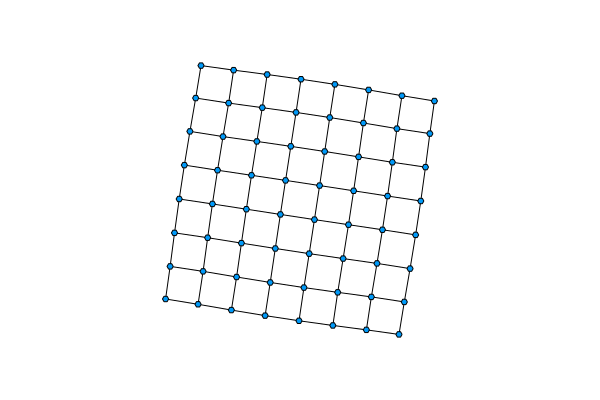

In [8]:
graphplot(adj, curves = false)

In [9]:
# Budget
Z = 2.5*ne(adj)

# Allocate investment equally
I0 = (Z/(2.001*ne(adj)))*A
index = findall(x -> x == 0, I0)
I0[index] .= 1e-2
I0 = I0.*A
I0 = (I0 + I0') / 2.0

64×64 Matrix{Float64}:
 0.0      1.24938  0.0      0.0      …  0.0      0.0      0.0      0.0
 1.24938  0.0      1.24938  0.0         0.0      0.0      0.0      0.0
 0.0      1.24938  0.0      1.24938     0.0      0.0      0.0      0.0
 0.0      0.0      1.24938  0.0         0.0      0.0      0.0      0.0
 0.0      0.0      0.0      1.24938     0.0      0.0      0.0      0.0
 0.0      0.0      0.0      0.0      …  0.0      0.0      0.0      0.0
 0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
 0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
 1.24938  0.0      0.0      0.0         0.0      0.0      0.0      0.0
 0.0      1.24938  0.0      0.0         0.0      0.0      0.0      0.0
 0.0      0.0      1.24938  0.0      …  0.0      0.0      0.0      0.0
 0.0      0.0      0.0      1.24938     0.0      0.0      0.0      0.0
 0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
 ⋮                                   ⋱  ⋮             

In [10]:
# Transport cost function
function transport_cost(delT,In,gamm,N,synth = true)
    if synth == true
        NN = N^2
    else
        NN = N
    end
       
    # Adjacency matrix
    Adj = zeros(NN,NN)
    idx = findall(x -> x > 0, In)
    Adj[idx] .= 1
    
    # Weights of the graph (in matrix form)
    W = (Adj .* delT) ./ (In.^(gamm))
    idnan = isnan.(W)
    W[idnan] .= 0
    W = W.*Adj
    
    # Weighted Graph
    G = SimpleWeightedGraph(NN)
    index = findall(x -> x == 1, Adj)
    rows = map(i -> i[1], index)
    cols = map(i -> i[2], index)
    rows = rows[:]
    cols = cols[:]
    edges = [rows cols]
    
    for (r, c) in zip(edges[:,1],edges[:,2])
        add_edge!(G, Int(r), Int(c), W[r,c])
    end
    
    # Compute shortest paths
    T = zeros(NN,NN)
    for ii in 1:NN
        tau = dijkstra_shortest_paths(G, ii)
        T[ii,:] = tau.dists
    end
    
    T[diagind(T)] .= 1
    T .= max.(1, T)
    T = (T + T') ./ 2.0
    
    return (T, G)
end

T, G = transport_cost(delT,I0,gamm,N)

([1.0 1.3259368717873725 … 16.488498552128654 17.704451057521183; 1.3259368717873725 1.0 … 15.255756048359446 16.47170855375197; … ; 16.488498552128654 15.255756048359446 … 1.0 1.4788079330930055; 17.704451057521183 16.47170855375197 … 1.4788079330930055 1.0], {64, 112} undirected simple Int64 graph with Float64 weights)

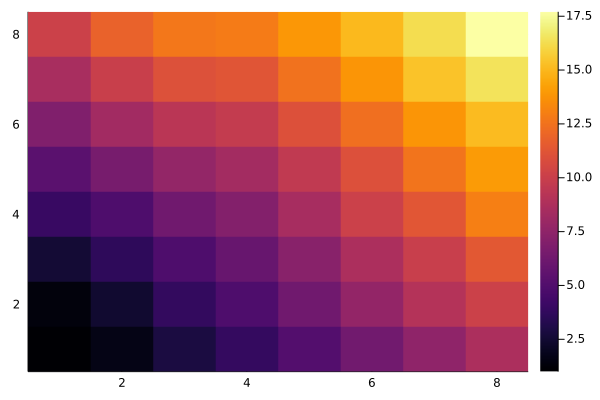

In [15]:
heatmap(reshape(T[1,:],N,N))